In [41]:
# pip install --upgrade mlflow

In [1]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Préparation des données

In [43]:
# app_test = pd.read_csv(r'application_test.csv')
# print('Testing data shape: ', app_test.shape)
# app_test.head()

In [2]:
app_train = pd.read_csv(r'application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
app_train['TARGET'].value_counts()


TARGET
0    282686
1     24825
Name: count, dtype: int64

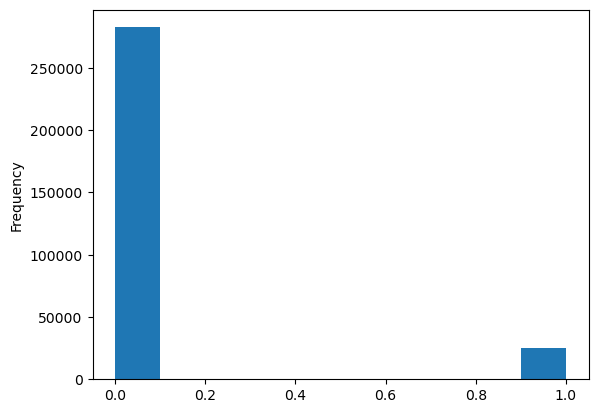

In [4]:
app_train['TARGET'].astype(int).plot.hist();


On a un fort déséquilibre entre les classes dans le jeu de données, les valeurs 1 sont beaucoup plus rares quue les 0.

In [5]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [6]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [7]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoding des variables catégorielles

Label encoding qui associe chaque catégorie à un chiffre arbitraire pour les variables qui n'ont que deux catégories et OneHot encoding pour les variables qui ont plus de deux catégories.

In [8]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            # app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [9]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
# app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)


In [52]:
# train_labels = app_train['TARGET']

# # Align the training and testing data, keep only columns present in both dataframes
# app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# # Add the target back in
# app_train['TARGET'] = train_labels

# print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', app_test.shape)

Le jeu de données de train et de test ont maintenant les mêmes dimensions, ce qui est requis pour faire du machine learning. 

# Analyses exploratoires des données

In [10]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Il ne semble pas y avoir d'âge abhérrant. 

In [11]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Là il y a un problème car les valeurs maximum sont bien trop grandes pour être réalistes.

Text(0.5, 0, 'Days Employment')

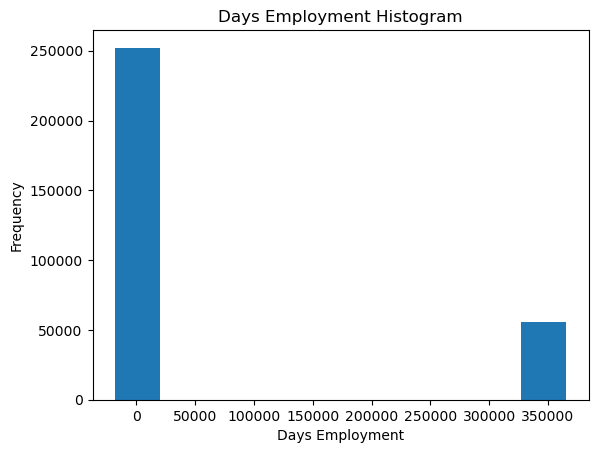

In [12]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [13]:
#Analyse approfondie des valeurs anormales de la variable DAYS_EMPLOYED
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


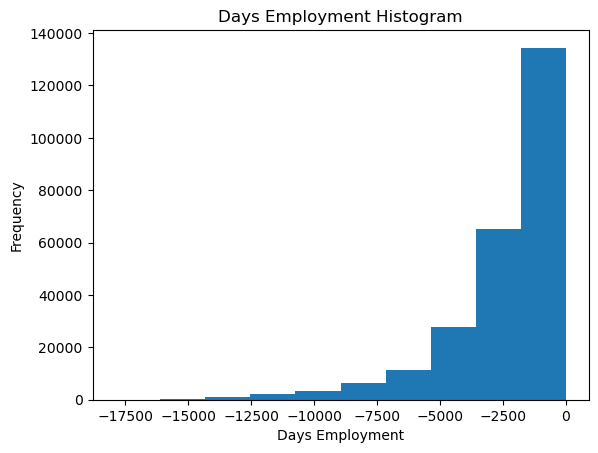

In [14]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [58]:
# app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
# app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# print('Il y a %d anomalies dans le jeu de données de test parmi %d données' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

In [15]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

L'âge est la plus importante corrélation positive, cependant cett evaleur étant négative (jour depuis la naissance des clients par rapport au jour du prêt) cela signifie que plus un client est âgé plus il y a de chance que le prêt soit remboursé à temps.

In [16]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982692)

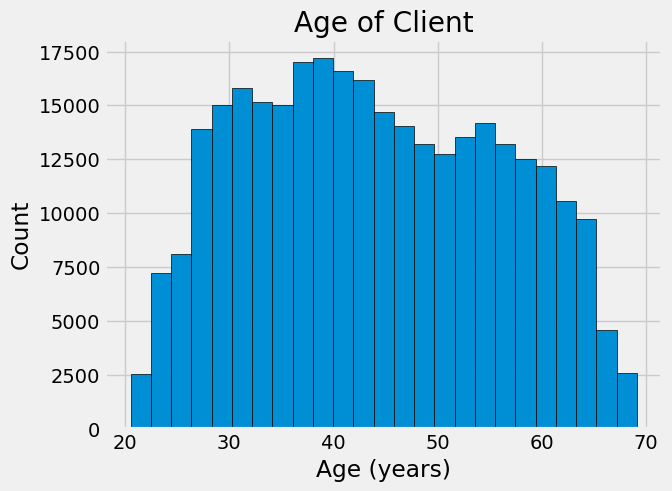

In [17]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

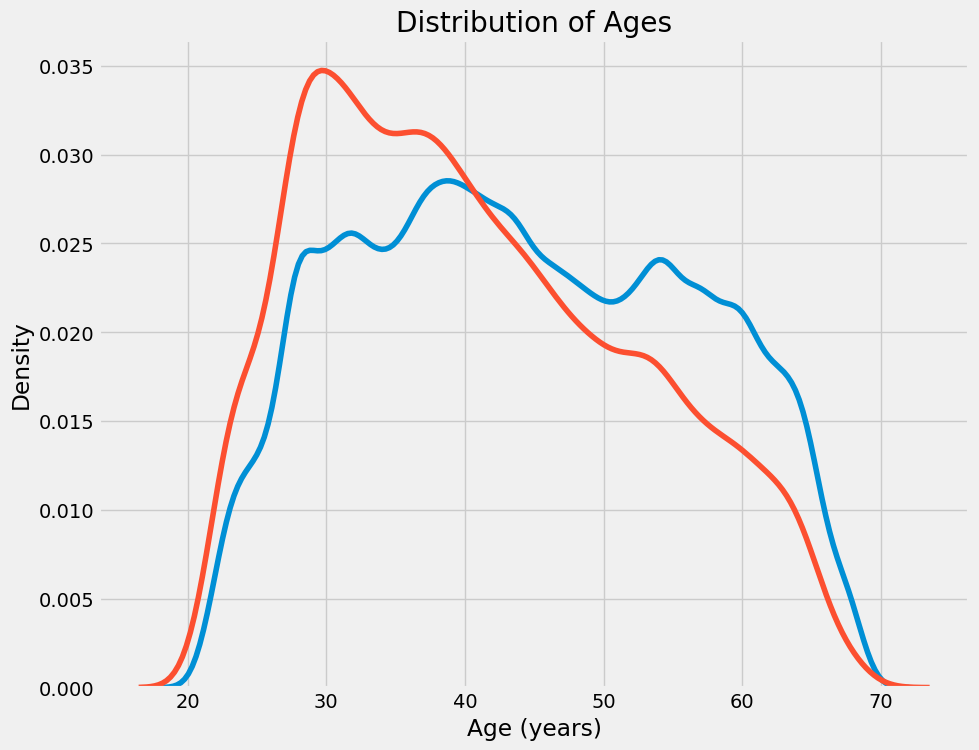

In [18]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


In [19]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\manon\AppData\Local\Temp\ipykernel_14384\1136001900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\manon\AppData\Local\Temp\ipykernel_14384\1136001900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [20]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

C:\Users\manon\AppData\Local\Temp\ipykernel_14384\3685359187.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


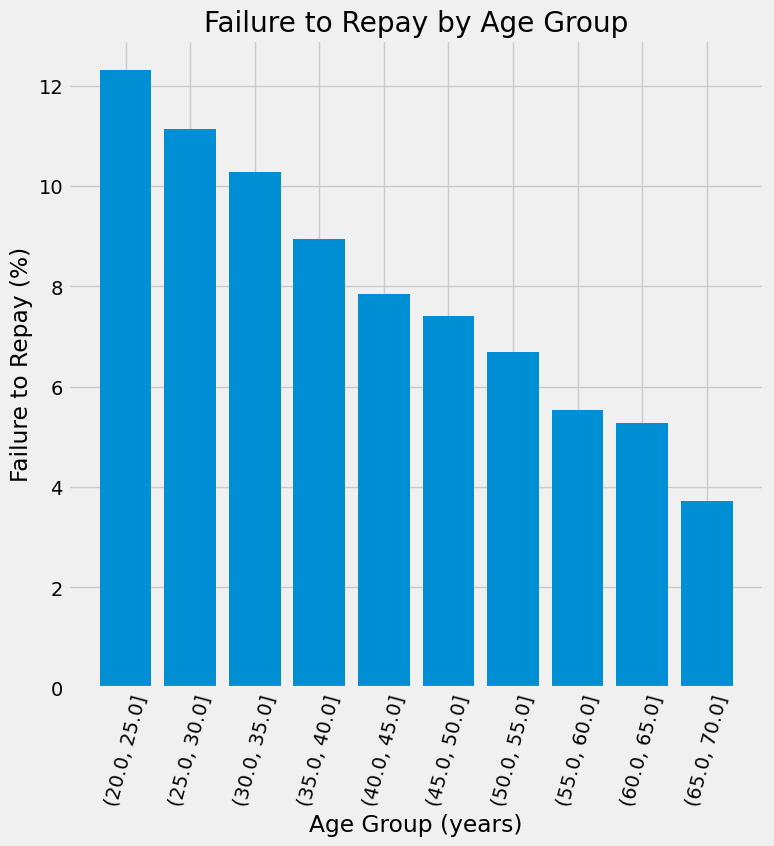

In [21]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [22]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


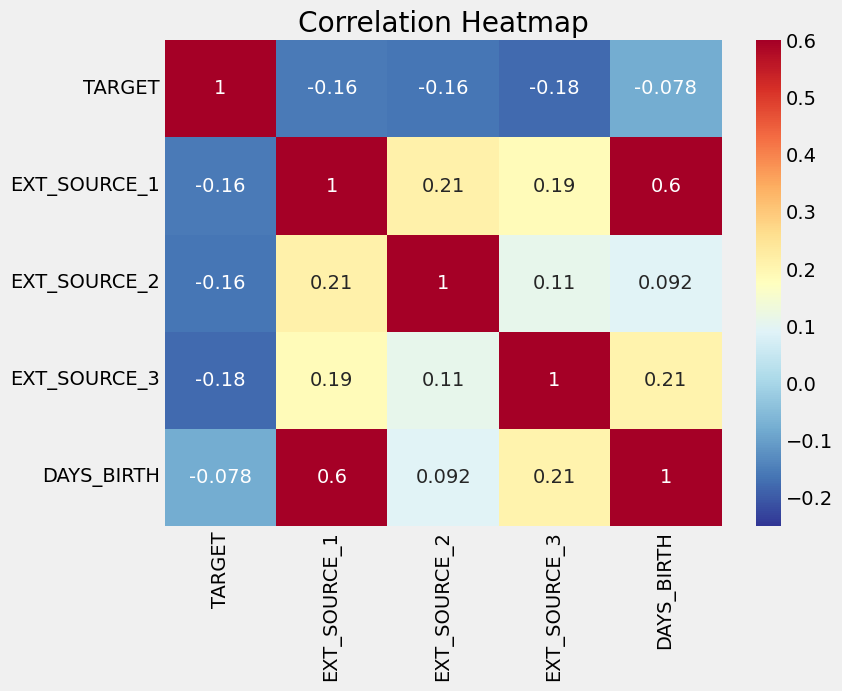

In [23]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

L'âge est fortement corrélée à la variable "External_source_1".

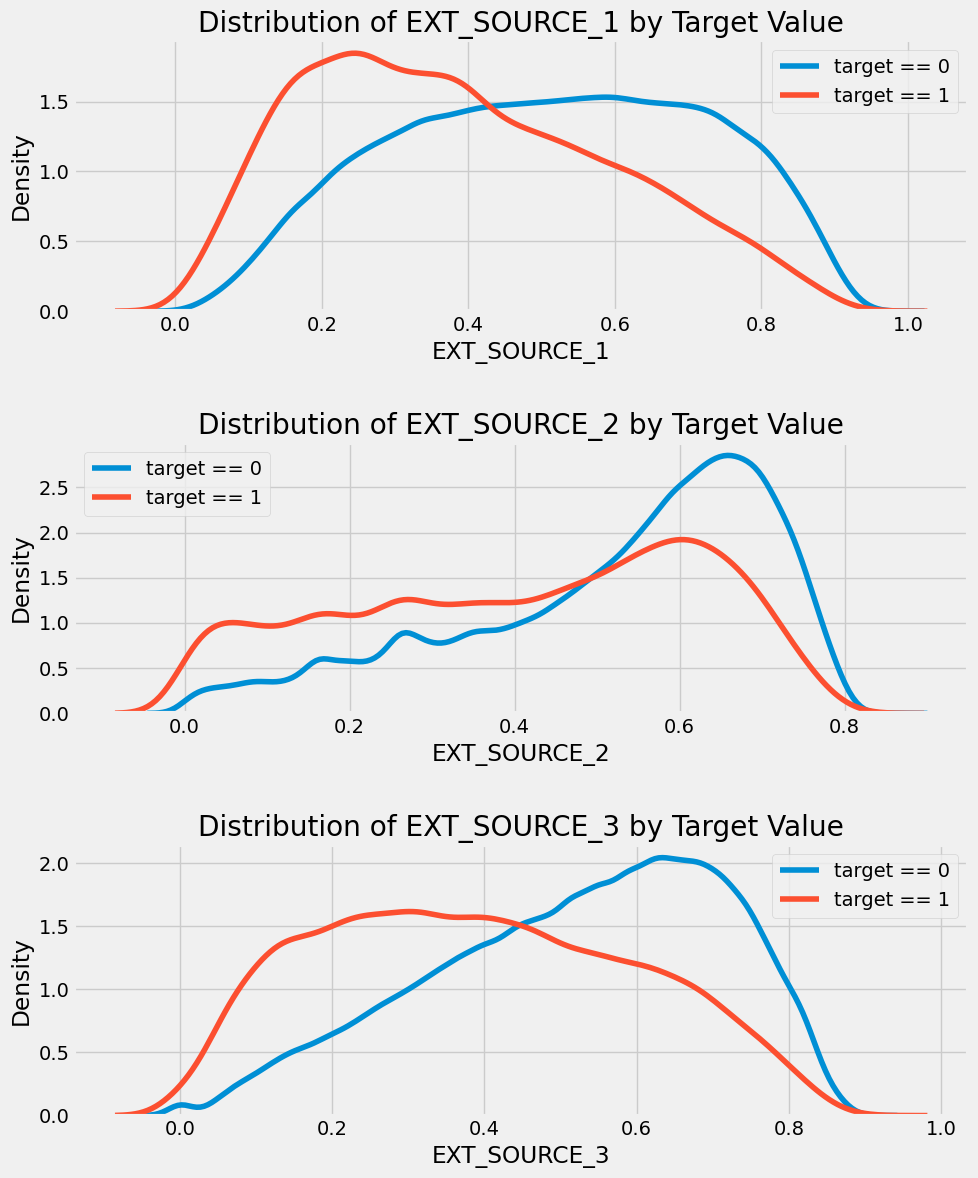

In [24]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap pa

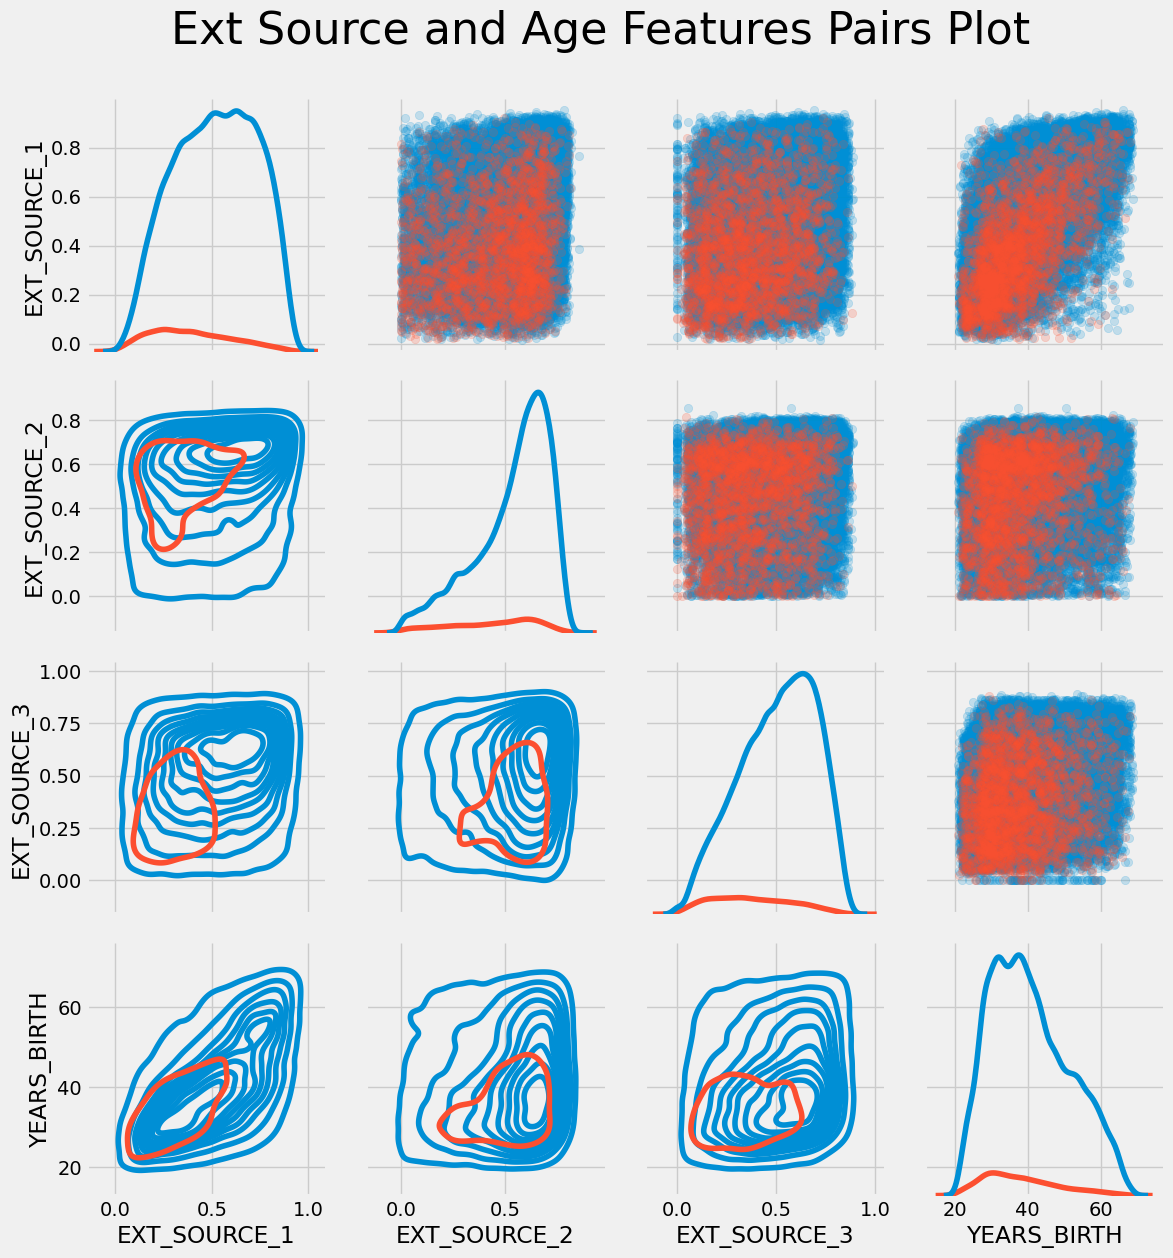

In [25]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Feature engineering

In [26]:
import numpy as np
import gc
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lightgbm import LGBMClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [28]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(df_path, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(df_path, nrows= num_rows)
    # test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Dataframe lengh: {}".format(len(df)))
    # df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # del test_df
    gc.collect()
    return df

In [29]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [30]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [31]:
def run_full_feature_engineering(df_path, debug = False):
    # Si debug=True, on ne charge que 10000 lignes pour tester vite
    num_rows = 10000 if debug else None
    
    # 1. On prépare la table principale
    print("Processing application train/test...")
    df = application_train_test(df_path, num_rows)
    print("Main table shape:", df.shape)
    
    # 2. On traite 'bureau' et on FUSIONNE (Left Join) sur SK_ID_CURR
    print("Processing bureau...")
    bureau = bureau_and_balance(num_rows)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau; gc.collect() # Important pour libérer la mémoire
    
    # 3. Idem pour les demandes précédentes
    print("Processing previous applications...")
    prev = previous_applications(num_rows)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev; gc.collect()
    
    # 4. Idem pour POS_CASH
    print("Processing POS-CASH balance...")
    pos = pos_cash(num_rows)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos; gc.collect()
    
    # 5. Idem pour les paiements échelonnés
    print("Processing installments payments...")
    ins = installments_payments(num_rows)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins; gc.collect()
    
    # 6. Idem pour les cartes de crédit
    print("Processing credit card balance...")
    cc = credit_card_balance(num_rows)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc; gc.collect()
    
    print("Final DataFrame shape:", df.shape)
    # On retourne le gros DataFrame final, prêt pour le Machine Learning
    return df

In [32]:
#Application de tout ce processus
train_df = run_full_feature_engineering(df_path = "application_train.csv", debug=False)

Processing application train/test...
Dataframe lengh: 307511
Main table shape: (307507, 247)
Processing bureau...
Processing previous applications...
Processing POS-CASH balance...
Processing installments payments...
Processing credit card balance...
Final DataFrame shape: (307507, 797)


In [33]:
train_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
train_df.isna().mean()

SK_ID_CURR                          0.000000
TARGET                              0.000000
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
FLAG_OWN_REALTY                     0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 797, dtype: float64

In [35]:
#Séparation des donnée spour créer le jeu de données train et test
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

del train_df
gc.collect()

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

del X, y
gc.collect()

print(f"Entraînement : {X_temp.shape[0]} lignes")
print(f"Test : {X_test.shape[0]} lignes")

Entraînement : 246005 lignes
Test : 61502 lignes


In [36]:
# Séparation du train en train et val pour avoir un jeu de données de  validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

del X_temp, y_temp
gc.collect()

print(f"Taille du nouveau jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de validation : {X_val.shape}")

Taille du nouveau jeu d'entraînement : (184503, 795)
Taille du jeu de validation : (61502, 795)


In [81]:
# mlflow.set_experiment("MLflow Quickstart")

# # Load the Iris dataset
# X, y = datasets.load_iris(return_X_y=True)

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Define the model hyperparameters
# params = {
#     "solver": "lbfgs",
#     "max_iter": 1000,
#     "multi_class": "auto",
#     "random_state": 8888,
# }

In [82]:
# # Enable autologging for scikit-learn
# mlflow.sklearn.autolog()

# # Just train the model normally
# lr = LogisticRegression(**params)
# lr.fit(X_train, y_train)

# Initialisation de l'environnment MLFlow

In [37]:
mlflow.set_experiment("Elaboration du modèle de scoring - P7 DS")

<Experiment: artifact_location='file:///c:/Users/manon/Documents/GitHub/OCProjet7/mlruns/914592985007891055', creation_time=1764863538590, experiment_id='914592985007891055', last_update_time=1764863538590, lifecycle_stage='active', name='Elaboration du modèle de scoring - P7 DS', tags={'mlflow.experimentKind': 'custom_model_development'}>

# Test de différents modèles

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer



In [85]:
# X_test = test_df.drop(columns=['SK_ID_CURR'])

# print("Shape de X_test :", X_test.shape)

In [39]:
def get_param_grid(model):
    name = model.__class__.__name__  #pour trouver le type de modèle, permet à la fonction d'être dynamique et de l'utiliser pour plusieurs types de modèles
    grids = {
        "LogisticRegression": {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        },
        "RandomForestClassifier": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__class_weight': ['balanced', None] #pour gérer le déséquilibre des classes
        },
        "XGBClassifier": {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [2, 3, 6],
            'model__scale_pos_weight': [1, 10], #pour gérer le déséquilibre des classes
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__random_state': [42],
            'model__use_label_encoder': [False], # Pour éviter un warning
            'model__eval_metric': ['logloss']
        }         
    }

    return grids.get(name, {})

In [87]:
# #Mise en place de la pipeline pour faire le preprocessing et la mise en place du modèle
# def pipeline_model(model_type, X_train, y_train, X_val, y_val):
#     model_name = model_type.__class__.__name__
#     with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
#         steps=[
#             ('imputer', SimpleImputer(strategy='median')), #gère les NaN
#             ('scaler', StandardScaler()), #standardisation des données
#             ('model', model_type)                        
#         ]

#         pipeline=Pipeline(steps=steps)

#         param_grid = get_param_grid(model_type)
        
#         print(f"Hyperparamètres pour {model_name} : {param_grid}")
        
#         mlflow.set_tag("model_type", model_name)
#         mlflow.set_tag("mlflow.runName", f"GS_{model_name}")

#         cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#         grid_search_model = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
#         grid_search_model.fit(X_train, y_train)

#         y_val_pred__dumb = grid_search_model.predict_proba(X_val)[:, 1]
#         val_auc = roc_auc_score(y_val, y_val_pred__dumb)
#         print(f"Score AUC sur validation : {val_auc:.4f}")
#         #Tracer de la courbe ROC
#         fpr, tpr, thresholds = roc_curve(y_val, y_val_pred__dumb)
#         fig, ax = plt.subplots(figsize=(8, 6))
#         ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
#         ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
#         ax.set_xlim([0.0, 1.0])
#         ax.set_ylim([0.0, 1.05])
#         ax.set_xlabel('Taux de Faux Positifs')
#         ax.set_ylabel('Taux de Vrais Positifs')
#         ax.set_title(f'Courbe ROC - Modèle {model_name}')
#         ax.legend(loc="lower right")
#         ax.grid(True)

#     return grid_search_model, val_auc, fig

In [40]:
def pipeline_model_wo_gs(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    with mlflow.start_run(run_name=f"Simple_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')), #gère les NaN
            ('scaler', StandardScaler()), #standardisation des données
            ('model', model_type)                        
        ]

        pipeline=Pipeline(steps=steps)

        mlflow.log_params(model_type.get_params())
        print(f"Entraînement direct de {model_name}...")
                
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("optimization", "None")

        pipeline.fit(X_train, y_train)

        y_val_pred__dumb = pipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred__dumb)
        print(f"Score AUC sur validation : {val_auc:.4f}")
        mlflow.log_metric("val_auc", val_auc)

        #Tracer de la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_val_pred__dumb)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)

        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return pipeline, val_auc, fig

## Modèle de base - Dummy

C'est le modèle de base qui va nous servir à comparer les modèles que nous allons tester. En effet, si leur performances sont équivalentes voire inférieures à celui-ci alors ces modèles ne seront pas à retenir pour répondre au client.

In [41]:
from sklearn.dummy import DummyClassifier

In [42]:
dumb_model = DummyClassifier(strategy="most_frequent")

In [43]:
with mlflow.start_run(run_name="Dummy Model"):
    dumb_model.fit(X_train, y_train)
    y_val_pred__dumb = dumb_model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred__dumb)
    print(f"Score AUC sur validation : {val_auc:.4f}")
    #Tracer de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred__dumb)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux de Faux Positifs')
    ax.set_ylabel('Taux de Vrais Positifs')
    ax.set_title('Courbe ROC - Modèle Dummy')
    ax.legend(loc="lower right")
    ax.grid(True)
    mlflow.log_figure(fig, "roc_curve_dumb.png")
    plt.close(fig)
    #Enregistrement du modèle dans MLflow
    mlflow.sklearn.log_model(dumb_model, "dummy_model")
    mlflow.log_param("strategy", "most_frequent")
    mlflow.log_metric("auc_score", val_auc)
    print("Run MLFlow terminé.")


2026/01/21 10:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Score AUC sur validation : 0.5000
Run MLFlow terminé.


## Régression logistique

In [44]:
#Le feature engineering a créé des valeur infini dan sle scolonnes résultant d'un ratio, je cherche où
X_train_numeric = X_train.select_dtypes(include=[np.number])

# Maintenant, on cherche les infinis
inf_columns = X_train_numeric.columns[np.isinf(X_train_numeric).any()]

print(f"Colonnes contenant des valeurs infinies : {list(inf_columns)}")
print(f"Nombre total de valeurs infinies : {np.isinf(X_train_numeric).sum().sum()}")

Colonnes contenant des valeurs infinies : ['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']
Nombre total de valeurs infinies : 31


In [45]:
# Je remplace ces valeurs par des NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)


# Vérification rapide
cols_to_check = ['PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_SUM']
print(X_train[cols_to_check].isin([np.inf, -np.inf]).sum())

PREV_APP_CREDIT_PERC_MAX    0
INSTAL_PAYMENT_PERC_SUM     0
dtype: int64


In [46]:
mlflow.sklearn.autolog()

In [95]:
# lr, auc_lr, fig_lr = pipeline_model_wo_gs(LogisticRegression(), X_train, y_train, X_val, y_val)

## Random Forest Classification

In [96]:
# rf, auc_rf, fig_rf = pipeline_model_wo_gs(RandomForestClassifier(), X_train, y_train, X_val, y_val)


## Modèle XGBoost

In [97]:
# xgb, auc_xgb, fig_xgb = pipeline_model_wo_gs(XGBClassifier(), X_train, y_train, X_val, y_val)

# Modèle LightGBM

In [47]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import re


In [99]:
# def clean_dataset_for_lgbm(df):
#     # Sélectionne les colonnes qui sont de type 'object' (texte)
#     obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    
#     if len(obj_cols) > 0:
#         print(f"⚠️ Correction de {len(obj_cols)} colonnes de type 'object'...")
#         for col in obj_cols:
#             # On force la conversion en numérique. 
#             # Les erreurs (texte qui n'est pas un nombre) deviennent NaN
#             df[col] = pd.to_numeric(df[col], errors='coerce')
    
#     print("✅ Types de données nettoyés. Prêt pour LightGBM.")
#     return df

# # Applique le nettoyage sur tes jeux de données
# X_train = clean_dataset_for_lgbm(X_train)
# X_val = clean_dataset_for_lgbm(X_val)

In [100]:
# def clean_feature_names(df):
#     # Remplace tous les caractères "interdits" par un underscore
#     # On garde seulement les lettres, chiffres et l'underscore
#     new_cols = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
    
#     # On assigne les nouveaux noms
#     df.columns = new_cols
#     print("✅ Noms de colonnes nettoyés pour LightGBM.")
#     return df

# # --- APPLIQUE ÇA AVANT TON GRIDSEARCH ---
# X_train = clean_feature_names(X_train)
# X_val = clean_feature_names(X_val)

In [101]:
# def grid_search_lightgbm_with_early_stopping(X_train, y_train, X_val, y_val):
    
#     # 1. On définit le modèle de base (sans hyperparamètres fixés, sauf le n_jobs)
#     lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=1) # n_jobs=1 pour laisser le GridSearch gérer les cœurs

#     # 2. La grille de paramètres à tester
#     # Note : On ne met pas de "model__" devant car il n'y a plus de pipeline !
#     param_grid ={
#             'n_estimators': [1000],
#             'learning_rate': [0.02, 0.05],
#             'num_leaves': [34, 50],
#             'colsample_bytree': [0.7, 0.9],
#             'subsample': [0.8, 1],
#             'scale_pos_weight': [1, 10], #pour gérer le déséquilibre des classes
#             'random_state': [42],
#             'n_jobs': [1]
#         }
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 folds pour aller plus vite
        
#     grid = GridSearchCV(
#         estimator=lgbm,
#         param_grid=param_grid,
#         cv=cv,
#         scoring='roc_auc',
#         verbose=1,
#         n_jobs=4
#     )

#     print("🚀 Lancement du GridSearch avec Early Stopping...")
        
#     grid.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],        # Le jeu de validation pour l'early stopping
#         eval_metric='auc',                # La métrique à surveiller
#         callbacks=[                       # Les callbacks LightGBM
#             lgb.early_stopping(stopping_rounds=100),
#             lgb.log_evaluation(period=0)  # period=0 pour ne pas spammer la console à chaque essai
#         ]
#     )

#     print(f"✅ Meilleur score AUC (interne CV) : {grid.best_score_:.4f}")
#     print(f"✅ Meilleurs paramètres : {grid.best_params_}")
    
#     return grid.best_estimator_

In [102]:
# best_lgbmmodel = grid_search_lightgbm_with_early_stopping(X_train, y_train, X_val, y_val)

# Calcule du score métier et du seuil

In [48]:
from sklearn.metrics import confusion_matrix, make_scorer


In [49]:
def calcul_score_metier(y_true, y_pred):
    # 1. Extraction des valeurs de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = (10 * fn) + fp
    
    return score

In [50]:
score_metier = make_scorer(calcul_score_metier, greater_is_better=False)
score_metier

make_scorer(calcul_score_metier, greater_is_better=False, response_method='predict')

In [51]:
def pipeline_model_score_simple(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"Simple_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model_type)                        
        ]

        pipeline = Pipeline(steps=steps)
        mlflow.log_params(model_type.get_params())
                
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("optimization", "None")

        pipeline.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        y_train_pred = pipeline.predict(X_train)
        train_cost = calcul_score_metier(y_train, y_train_pred)
        print(f"Coût métier sur le train : {train_cost:.2f}")
        mlflow.log_metric("train_business_cost", train_cost) 

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = pipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = pipeline.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return pipeline, val_auc, fig, val_cost

In [ ]:
def pipeline_model_score(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model_type)                        
        ]

        pipeline = Pipeline(steps=steps)
        param_grid = get_param_grid(model_type)
        
        print(f"Hyperparamètres pour {model_name} : {param_grid}")
        
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("mlflow.runName", f"GS_{model_name}")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        grid_search_model = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=cv, 
            scoring=score_metier, # <--- C'est ici que la magie opère
            verbose=1, 
            n_jobs=2
        )
        
        grid_search_model.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        best_cost = abs(grid_search_model.best_score_)
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = grid_search_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = grid_search_model.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return grid_search_model, val_auc, fig, val_cost

In [53]:
def grid_search_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val):
    model_name = "LGBMClassifier"
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
    
    # 1. On définit le modèle de base (sans hyperparamètres fixés, sauf le n_jobs)
        lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=1) # n_jobs=1 pour laisser le GridSearch gérer les cœurs

    # 2. La grille de paramètres à tester
    # Note : On ne met pas de "model__" devant car il n'y a plus de pipeline !
        param_grid ={
                'n_estimators': [1000],
                'learning_rate': [0.02, 0.05],
                'num_leaves': [34, 50],
                'colsample_bytree': [0.7, 0.9],
                'subsample': [0.8, 1],
                'max_depth': [8, -1],
                'class_weight': [None, 'balanced'], #pour gérer le déséquilibre des classes
                'random_state': [42],
                'n_jobs': [2]
            }
        
        mlflow.set_tag("model_type", model_name)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 folds pour aller plus vite
            
        grid = GridSearchCV(
            estimator=lgbm,
            param_grid=param_grid,
            cv=cv,
            scoring=score_metier,
            verbose=1,
            n_jobs=2
        )

        print("🚀 Lancement du GridSearch avec Early Stopping...")
            
        grid.fit(
            X_train_proc, y_train,
            eval_set=[(X_val_proc, y_val)],        # Le jeu de validation pour l'early stopping
            eval_metric='auc', #mieux que le score directement car mon score n'est pas une variable continue
            callbacks=[                       # Les callbacks LightGBM
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)  # period=0 pour ne pas spammer la console à chaque essai
            ]
        )
        best_cost = abs(grid.best_score_) #car le score retourner est négatif avec greater_is_better=False
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        clean_params = grid.best_params_.copy()
        clean_params.pop('n_jobs', None)
        
        mlflow.log_params(clean_params)
        # mlflow.log_params(grid.best_params_)
        y_val_pred = grid.predict(X_val_proc) # Prédictions dures (0 ou 1)
        y_val_probs = grid.predict_proba(X_val_proc)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        # On calcule le coût réel sur la validation
        real_cost_val = calcul_score_metier(y_val, y_val_pred)
        
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

        print(f"✅ Meilleur score score métier (CV) : {grid.best_score_:.4f}")
        print(f"✅ Meilleurs paramètres : {grid.best_params_}")
        
        return grid.best_estimator_, val_auc, real_cost_val, fig

2026/01/20 14:17:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/20 14:18:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

🚀 Lancement du GridSearch avec Early Stopping...


2026/01/20 14:19:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Fitting 3 folds for each of 64 candidates, totalling 192 fits


c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 14895, number of negative: 169608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.719725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99384
[LightGBM] [Info] Number of data points in the train set: 184503, number of used features: 724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's auc: 0.784652	valid_0's binary_logloss: 0.495288


c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

Meilleur coût métier moyen sur le CV : 30641.67


c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Meilleur score score métier (CV) : -30641.6667
✅ Meilleurs paramètres : {'class_weight': 'balanced', 'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': -1, 'n_estimators': 1000, 'n_jobs': 2, 'num_leaves': 50, 'random_state': 42, 'subsample': 0.8}


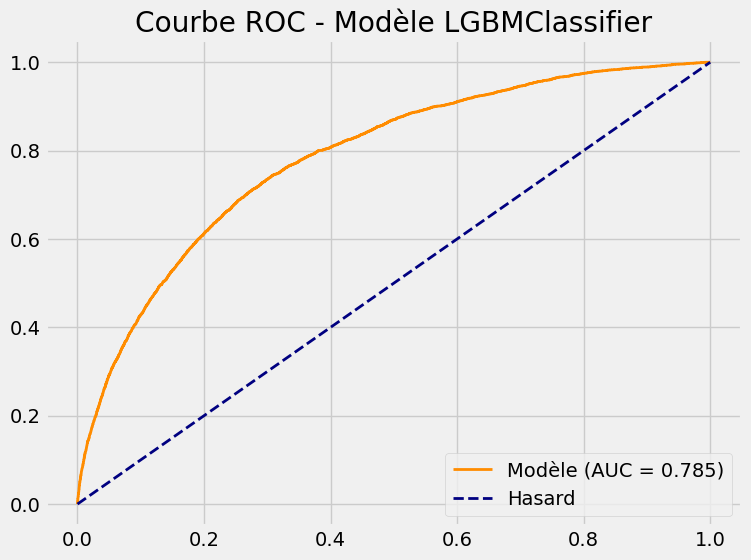

In [109]:
best_lgbmmodel, lgbm_auc, lgbm_score, fig_lgbm = grid_search_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val)

2026/01/21 13:52:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100

Coût métier sur le train : 144189.00
Score AUC sur validation : 0.7684
Coût Métier sur validation : 48052 €


2026/01/21 13:55:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 14:01:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

Coût métier sur le train : 10.00
Score AUC sur validation : 0.7111
Coût Métier sur validation : 49562 €


2026/01/21 14:05:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 14:05:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

Coût métier sur le train : 119001.00


2026/01/21 14:08:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 14:08:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

Score AUC sur validation : 0.7651
Coût Métier sur validation : 46700 €


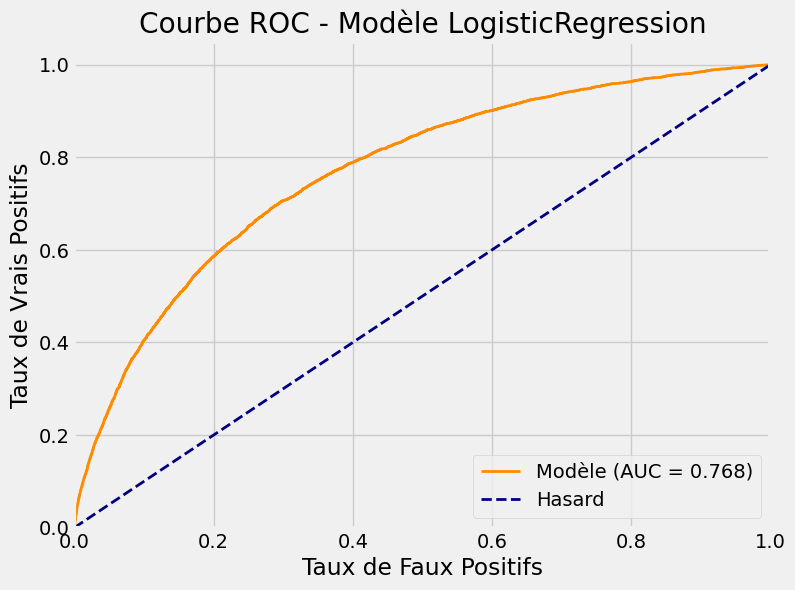

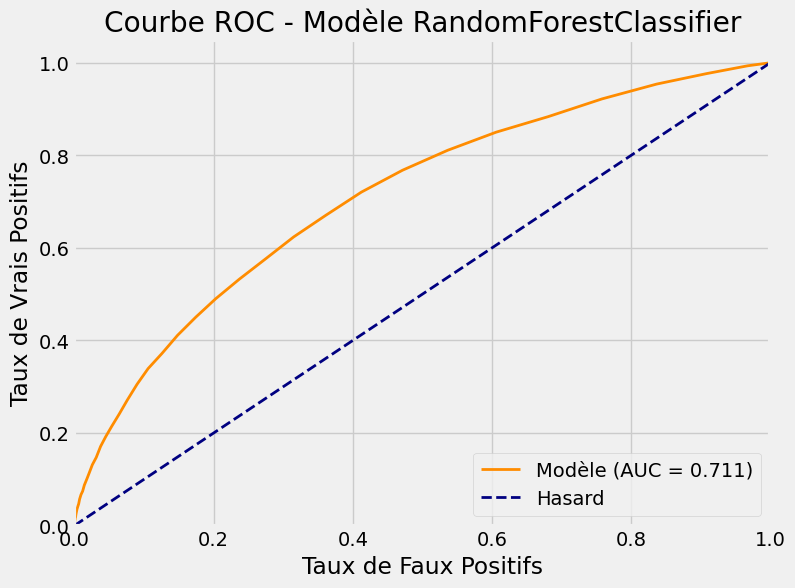

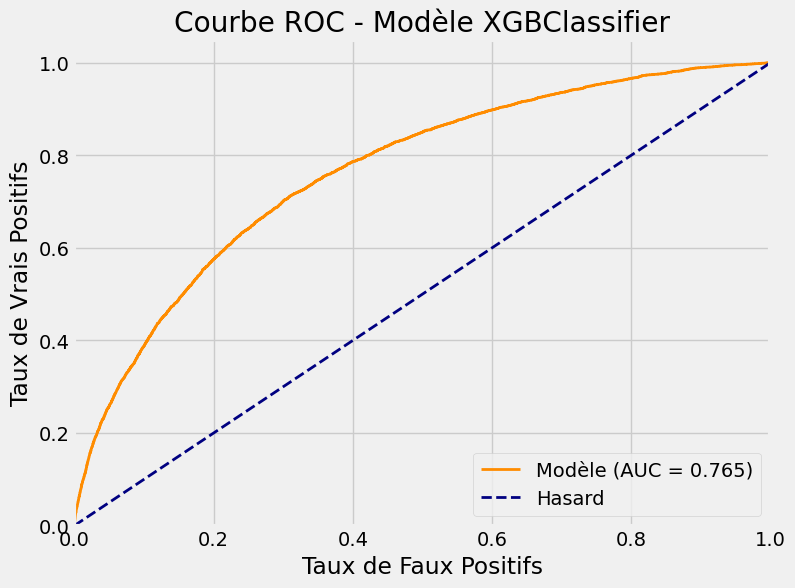

In [58]:
models_list = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]

score_model_df = pd.DataFrame(columns=["Modèle", "AUC", "Score métier"])
for model in models_list:
    pipeline, val_auc, fig, val_cost = pipeline_model_score_simple(model, X_train, y_train, X_val, y_val)
    score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": f"{model.__class__.__name__}_simple",
        "AUC": val_auc,
        "Score métier": val_cost
    }])], ignore_index=True)

In [59]:
print(score_model_df)

                          Modèle       AUC Score métier
0      LogisticRegression_simple  0.768433        48052
1  RandomForestClassifier_simple  0.711139        49562
2           XGBClassifier_simple  0.765116        46700


In [60]:
for model in models_list:
    grid_search_model, val_auc, fig, val_cost = pipeline_model_score(model, X_train, y_train, X_val, y_val)
    score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": f"{model.__class__.__name__}_GS",
        "AUC": val_auc,
        "Score métier": val_cost
    }])], ignore_index=True)

Hyperparamètres pour LogisticRegression : {'model__C': [0.001, 0.01, 0.1, 1, 10, 100], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}


2026/01/21 14:10:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": "LightGBM",
        "AUC": lgbm_auc,
        "Score métier": lgbm_score
    }])], ignore_index=True)
print(score_model_df)

## Introduction de l'oversampling

In [ ]:
# pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
def pipeline_model_smote(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"SMOTE_{model_name}", nested=True) as child_run:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model_type)
        ]

        imbpipeline = ImbPipeline(steps=steps)
        mlflow.log_params(model_type.get_params())
        mlflow.log_param("sampling_strategy", "SMOTE")

        print(f"Entraînement avec SMOTE de {model_name}...")

        imbpipeline.fit(X_train, y_train)

        # AUC
        y_val_probs = imbpipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)

        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # Graphique
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - {model_name} avec SMOTE')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        plt.close(fig)

    return imbpipeline, val_auc, fig, val_cost

In [ ]:
import datetime


def smote_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val):
    model_name = "LGBMClassifier"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    with mlflow.start_run(run_name=f"SMOTE_{model_name}_{timestamp}", nested=True) as child_run:
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
    
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_proc, y_train)

        lgbm_smote = lgb.LGBMClassifier(
            n_estimators=1000,     # Nombre d'arbres
            learning_rate=0.05,    # Vitesse d'apprentissage standard
            num_leaves=31,         # Valeur par défaut classique
            random_state=42
        ) 
        
        mlflow.log_params(lgbm_smote.get_params())
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("optimization", "EarlyStopping")
        mlflow.set_tag("sampling_strategy", "SMOTE")
        
        lgbm_smote.fit(
            X_train_smote, y_train_smote,
            eval_set=[(X_val_proc, y_val)],  # Le jeu de validation sert à arrêter l'entraînement
            eval_metric='auc',               # On surveille l'AUC
            callbacks=[
                lgb.early_stopping(stopping_rounds=50), # Arrêt si pas d'amélioration pendant 50 rounds
                lgb.log_evaluation(period=100)          # Affiche le score tous les 100 arbres
            ])

        y_val_probs = lgbm_smote.predict_proba(X_val_proc)[:, 1]
        y_val_pred = lgbm_smote.predict(X_val_proc)
        
        val_auc = roc_auc_score(y_val, y_val_probs)
        val_cost = calcul_score_metier(y_val, y_val_pred) 
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)
        mlflow.log_metric("best_iteration", lgbm_smote.best_iteration_)

        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - {model_name} (SMOTE + EarlyStop)')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        
        # On sauvegarde le modèle brut ici.
        mlflow.sklearn.log_model(lgbm_smote, f"model_{model_name}")
        plt.close(fig)

    return lgbm_smote, val_auc, val_cost, fig

In [ ]:
imbpipeline, val_auc, fig, val_cost = pipeline_model_smote(XGBClassifier(), X_train, y_train, X_val, y_val)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "XGBClassifier_SMOTE",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

In [ ]:
rfsmotepipeline, val_auc, fig, val_cost = pipeline_model_smote(RandomForestClassifier(), X_train, y_train, X_val, y_val)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "RandomForestClassifier_SMOTE",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

In [ ]:
smote_lgbmmodel, lgbm_auc, lgbm_score, fig_lgbm = smote_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": "LightGBM_smote",
        "AUC": lgbm_auc,
        "Score métier": lgbm_score
    }])], ignore_index=True)

In [ ]:
print(score_model_df)

Je tente d'associer GS et SMOTE sur les meilleursd modèles.

In [ ]:
def pipeline_model_gs_os(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model_type)
            ]

        final_pipeline = ImbPipeline(steps=steps)
        param_grid = get_param_grid(model_type)
        
        print(f"Hyperparamètres pour {model_name} : {param_grid}")
        
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("mlflow.runName", f"GS_{model_name}")

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        gs_os_model = GridSearchCV(
            final_pipeline, 
            param_grid, 
            cv=cv, 
            scoring=score_metier, # <--- C'est ici que la magie opère
            verbose=1, 
            n_jobs=-1
        )
        
        gs_os_model.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        best_cost = abs(gs_os_model.best_score_)
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = gs_os_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = gs_os_model.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return gs_os_model, val_auc, fig, val_cost

In [ ]:
gs_os_pipeline, val_auc, fig, val_cost = pipeline_model_gs_os(XGBClassifier(), X_train, y_train, X_val, y_val)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "XGBClassifier_GS_OS",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

In [ ]:
gs_ds_rfpipeline, val_auc, fig, val_cost = pipeline_model_gs_os(RandomForestClassifier(), X_train, y_train, X_val, y_val)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "RandomForestClassifier_GS_OS",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

In [ ]:
print(score_model_df.sort_values(by='Score métier'))

Le meilleur modèle selon le score métier est donc l'utilisation d'un algorithme de Random Forest classifier avec une optimisation des hyperparamètres.

## Optimisation du seuil de probabiblité

In [ ]:
best_model, val_auc, fig, val_cost = pipeline_model_score(RandomForestClassifier(), X_train, y_train, X_val, y_val)


In [ ]:
y_val_probs = best_model.predict_proba(X_val)[:, 1]

In [ ]:
def find_best_threshold(a, b, c, y_true, y_probs, cost_function):
    thresholds = np.linspace(a, b, c) # On teste de 0.4 à 0.5
    costs = []
    
    for t in thresholds:
        # On transforme la proba en prédiction binaire selon le seuil t
        y_pred = (y_probs >= t).astype(int)
        # On calcule le coût avec ta fonction existante
        cost = cost_function(y_true, y_pred)
        costs.append(cost)
    
    best_t = thresholds[np.argmin(costs)]
    min_cost = min(costs)
    return best_t, min_cost, thresholds, costs

In [ ]:
best_threshold, min_cost, thresholds, costs = find_best_threshold(0, 1, 101, y_val, y_val_probs, calcul_score_metier)

print(f"Seuil optimal : {best_threshold:.2f}")
print(f"Nouveau coût métier minimum : {min_cost}")

In [ ]:
# Représentation graphique du coût en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, color='blue', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Optimisation du Seuil Métier')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Coût Métier (Total)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_threshold, min_cost, thresholds, costs = find_best_threshold(0.45, 0.55, 31, y_val, y_val_probs, calcul_score_metier)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, color='blue', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Optimisation du Seuil Métier')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Coût Métier (Total)')
plt.legend()
plt.grid(True)
plt.show()

## Application au test

In [ ]:
# import re

In [ ]:
# X_test.columns = [re.sub(r'[ ]', '_', col) for col in X_test.columns]

In [ ]:
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
y_test_probs = best_model.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
y_test_preds = (y_test_probs >= best_threshold).astype(int)

In [ ]:
auc_test = roc_auc_score(y_test, y_test_probs)
print(f"L'AUC sur le jeu de test est de : {auc_test:.4f}")